In [1]:
from utils.tumor import get_tumor_location

ModuleNotFoundError: No module named 'torch'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

def get_df(lung_real,lung_fake):
    output_list = []
    for item in lung_real:
        print("#")
        print(item)
        for phase_index in range(len(item)):
            output_list.append(["Real",phase_index]+[item[phase_index]])
    for item in lung_fake:
        for phase_index in range(len(item)):
            output_list.append(["Fake",phase_index]+[item[phase_index]])
    df=pd.DataFrame(output_list,columns=['label','phase', 'volume(%)'])
    return(df)

def get_percent(array):
    #print(list)
    pass_check = True
    output = np.zeros(array.shape)
    for p_number in range(array.shape[0]):
        max_volume = np.max(array[p_number,:])
        # first = array[p_number,0]
        # output[p_number,0] = 0
        for t_index in range(10):
            item = array[p_number,t_index]
            print("#")
            print(item,max_volume)
            if np.mean(max_volume - item)<0:
                pass_check = False
                output[p_number,t_index]=((max_volume-item)*100/max_volume)
            else:
                output[p_number,t_index]=((max_volume-item)*100/max_volume)

    return output
    
def plot_volume(lung_real,lung_fake):
    lung_real = get_percent(lung_real)
    lung_fake = get_percent(lung_fake)
    #print(lung_fake.shape)
    print(lung_real[0])
    x = np.arange(len(lung_real[0]))
    radio = 1
    std_real = np.std(lung_real,axis=0)*radio
    mean_real = np.mean(lung_real,axis=0)
    mean_fake = np.mean(lung_fake,axis=0)
    std_fake = np.std(lung_fake,axis=0)*radio
    plt.figure(dpi=200)
    plt.fill_between(x, mean_real-std_real,mean_real+std_real, alpha=0.2,label="Real std") 
    plt.fill_between(x, mean_fake-std_fake,mean_fake+std_fake, alpha=0.2,label="Fake std")
    plt.plot(x,mean_real,label="Real Mean")#,color='red')
    plt.plot(x,mean_fake,label="Fake Mean")#,color="blue")
    df = get_df(lung_real,lung_fake)
    sns.boxplot(
        x="phase",
        y="volume(%)", 
        data=df,
        hue="label",  # 引入参数
        fliersize=0,
        whis=1.2,
        showfliers = False
    )
    plt.legend()
    plt.ylabel("Lung Volume(%)")
    plt.xlabel("Phase")
    plt.xticks([0,1,2,3,4,5,6,7,8,9],["t0","t1","t2","t3","t4","t5","t6","t7","t8","t9"])
    #plt.yticks([0,5,10,15,20,25,30])
    plt.show()

#
91.10257340565727 95.65399852087126
#
70.26282246059004 95.65399852087126
#
38.66127650071651 95.65399852087126
#
22.394943770992214 95.65399852087126
#
12.101293841850069 95.65399852087126
#
6.0339609939155885 95.65399852087126
#
9.198100883791746 95.65399852087126
#
33.88822776727174 95.65399852087126
#
73.84423610695924 95.65399852087126
#
95.65399852087126 95.65399852087126
#
100.81886510428643 100.81886510428643
#
79.96625925487268 100.81886510428643
#
46.875791056639166 100.81886510428643
#
14.503667283898906 100.81886510428643
#
4.433400201305473 100.81886510428643
#
5.654273738302062 100.81886510428643
#
5.160790579993338 100.81886510428643
#
22.188625456682395 100.81886510428643
#
60.46670020382285 100.81886510428643
#
97.28482743564979 100.81886510428643
#
97.10607008635905 98.2471571518719
#
72.00046716542056 98.2471571518719
#
42.565852783386696 98.2471571518719
#
23.353350690689876 98.2471571518719
#
10.578410296467975 98.2471571518719
#
6.108698557959816 98.247157151871

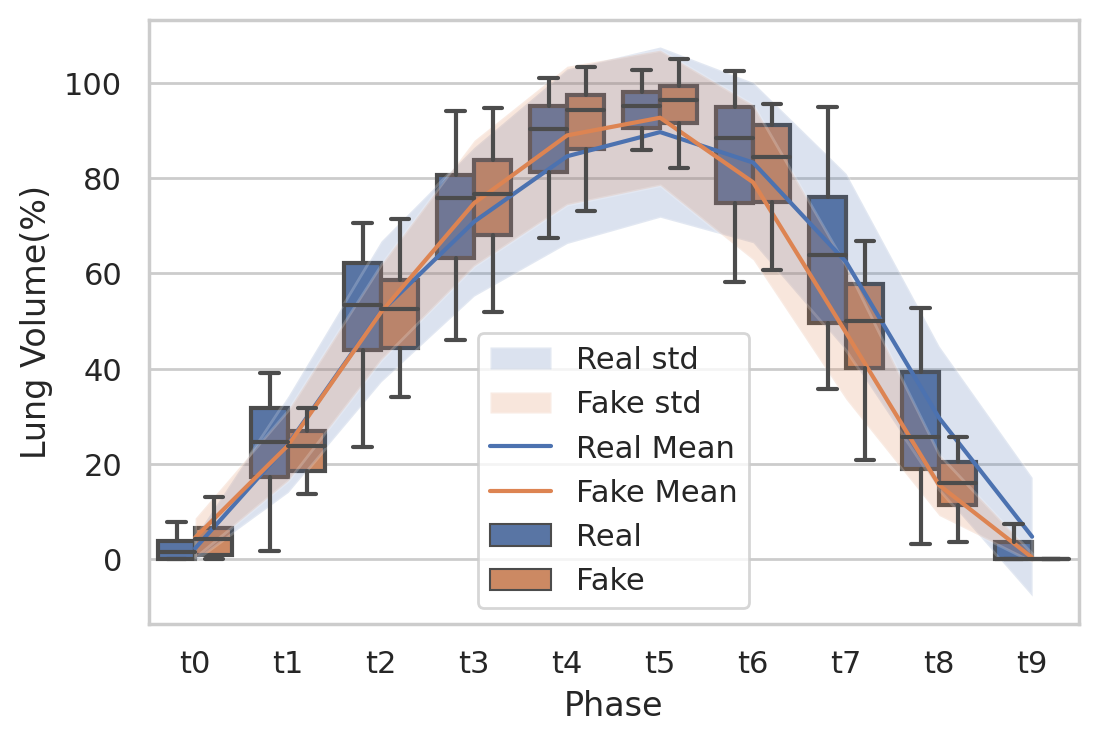

In [ ]:

left_fake = np.load("/mnt/zhaosheng/FNet/postprocess/fake_result_all.npy",allow_pickle=True)
left_real = np.load("/mnt/zhaosheng/FNet/postprocess/real_result_all.npy",allow_pickle=True)

plot_volume(left_real,left_fake)

In [31]:
left_fake.shape

(44, 10)

In [43]:
left_real[1]

array([100.8188651 ,  79.96625925,  46.87579106,  14.50366728,
         4.4334002 ,   5.65427374,   5.16079058,  22.18862546,
        60.4667002 ,  97.28482744])

In [20]:
import numpy as np
import ants
import os
from IPython import embed
from cfg import real_nii_path
from cfg import tumor_path
from cfg import output_path
from cfg import EPOCH
from monai.networks.blocks import Warp
import torch
warp_layer = Warp()

def get_result(output_path,epoch,type="_ddf_fake"):
    return sorted([os.path.join(output_path,_file) for _file in os.listdir(output_path) 
                if _file.startswith(f"{epoch}_") and str(type) in _file
            ],key=lambda x:x.split("_")[1])

def get_loc(ddf,ct,mask):
    assert ct.shape == mask.shape
    ddf_x = ddf[0]
    ddf_y = ddf[1]
    ddf_z = ddf[2]
    ct[mask<0.5]=0
    ddf_x[mask<0.5]=0
    ddf_y[mask<0.5]=0
    ddf_z[mask<0.5]=0
    x_mean = np.mean(ddf_x[mask>0])
    # print(ddf_x[mask>0].shape)
    y_mean = np.mean(ddf_y[mask>0])
    z_mean = np.mean(ddf_z[mask>0])
    # embed()
    return x_mean,y_mean,z_mean

def plot_loc(ddf,ct,mask):
    ct = ct+1000
    ants.plot(mask)


    raw_mask = torch.FloatTensor(mask.numpy()).unsqueeze(dim=0).unsqueeze(dim=0)
    ddf = torch.tensor(ddf).cuda().unsqueeze(dim=0)
    print(raw_mask.shape)
    print(ddf.shape)
    new_mask_array = warp_layer(raw_mask,ddf).cpu().detach().numpy()[0,0]
    print(new_mask_array.shape)
    new_mask = mask.new_image_like(new_mask_array)


    ants.plot(new_mask)

/home/lyxx/anaconda3/envs/ly_pro/lib/python3.9/site-packages/monai/networks/blocks/warp.py:66: UserWarning:

monai.networks.blocks.Warp: Using PyTorch native grid_sample.



**344311
	#T5


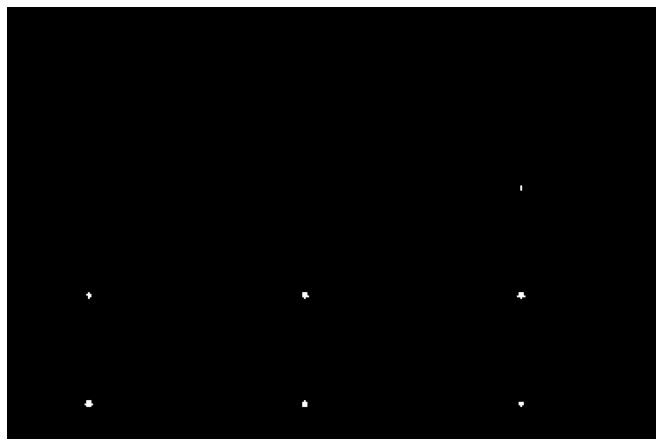

torch.Size([1, 1, 128, 128, 64])
torch.Size([1, 3, 128, 128, 64])


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [21]:

fake_images = get_result(output_path,EPOCH,"_image_fake")
real_images = get_result(output_path,EPOCH,"_image_real")
fake_ddfs = get_result(output_path,EPOCH,"_ddf_fake")
real_ddfs = get_result(output_path,EPOCH,"_ddf_real")

error = []
for index in range(len(real_ddfs)):
    pname = fake_images[index].split("/")[-1].split("_")[1]
    print(f"**{pname}")
    ddfs_fake = np.load(os.path.join(output_path,f"{EPOCH}_{pname}_ddf_fake.npy")).reshape((9,3,128,128,64))
    ddfs_real = np.load(os.path.join(output_path,f"{EPOCH}_{pname}_ddf_real.npy")).reshape((9,3,128,128,64))
    ct = ants.image_read(os.path.join(real_nii_path,f"{pname}_t0_resampled.nii"))#.numpy()
    mask = ants.image_read(os.path.join(tumor_path,f"{pname}_t0_Segmentation.seg.nrrd"))#.numpy()
    i = 5

    print(f"\t#T{i}")
    ddf_fake = ddfs_fake[i]
    ddf_real = ddfs_real[i]
    plot_loc(ddf_fake,ct,mask)
    break

In [ ]:
import numpy as np
import ants
import os
from IPython import embed
from cfg import real_nii_path
from cfg import tumor_path
from cfg import output_path
from cfg import EPOCH
from monai.networks.blocks import Warp
import torch
import matplotlib.pyplot as plt

warp_layer = Warp()

def get_result(output_path,epoch,type="_ddf_fake"):
    return sorted([os.path.join(output_path,_file) for _file in os.listdir(output_path) 
                if _file.startswith(f"{epoch}_") and str(type) in _file
            ],key=lambda x:x.split("_")[1])

def get_loc(ddf,ct,mask):
    assert ct.shape == mask.shape

    mean_loc = np.mean(mask)
    plt.figure()
    plt.plot(mask[:,:,int(mean_loc[2])])
    plt.show()

    plt.figure()
    plt.plot(ct[:,:,int(mean_loc[2])])
    plt.show()

    ddf_x = ddf[0]
    ddf_y = ddf[1]
    ddf_z = ddf[2]
    ct[mask<0.5]=0
    ddf_x[mask<0.5]=0
    ddf_y[mask<0.5]=0
    ddf_z[mask<0.5]=0
    x_mean = np.mean(ddf_x[mask>0])
    # print(ddf_x[mask>0].shape)
    y_mean = np.mean(ddf_y[mask>0])
    z_mean = np.mean(ddf_z[mask>0])
    # embed()
    return x_mean,y_mean,z_mean

def plot_loc(ddf,ct,mask):
    ct = ct+1000
    ants.plot(mask)


    raw_mask = torch.FloatTensor(mask.numpy()).unsqueeze(dim=0).unsqueeze(dim=0)
    ddf = torch.tensor(ddf).cuda().unsqueeze(dim=0)
    print(raw_mask.shape)
    print(ddf.shape)
    new_mask_array = warp_layer(raw_mask,ddf).cpu().detach().numpy()[0,0]
    print(new_mask_array.shape)
    new_mask = mask.new_image_like(new_mask_array)


    ants.plot(new_mask)


fake_images = get_result(output_path,EPOCH,"_image_fake")
real_images = get_result(output_path,EPOCH,"_image_real")
fake_ddfs = get_result(output_path,EPOCH,"_ddf_fake")
real_ddfs = get_result(output_path,EPOCH,"_ddf_real")

error = []
for index in range(len(real_ddfs)):
    pname = fake_images[index].split("/")[-1].split("_")[1]
    print(f"**{pname}")
    ddfs_fake = np.load(os.path.join(output_path,f"{EPOCH}_{pname}_ddf_fake.npy")).reshape((9,3,128,128,64))
    ddfs_real = np.load(os.path.join(output_path,f"{EPOCH}_{pname}_ddf_real.npy")).reshape((9,3,128,128,64))
    ct = ants.image_read(os.path.join(real_nii_path,f"{pname}_t0_resampled.nii"))#.numpy()
    mask = ants.image_read(os.path.join(tumor_path,f"{pname}_t0_Segmentation.seg.nrrd"))#.numpy()
    i = 5

    print(f"\t#T{i}")
    ddf_fake = ddfs_fake[i]
    ddf_real = ddfs_real[i]
    plot_loc(ddf_fake,ct,mask)
    break
